# G03 Scatter, LOESS, error bar, pairplot, heatmap

## Mục đích

Trong bài này, chúng ta sẽ tìm hiểu cách vẽ một số loại biểu đồ để khảo sát tương quan giữa hai biến liên tục. Ngoài ra chúng ta cũng làm quen với error bar, một công cụ quan trọng trong đồ họa.


## Scatter plot

Khi bạn cần khảo sát mối quan hệ giữa hai biến liên tục, scatter plot là một công cụ quan trọng. Bạn nên vẽ scatter plot (và phân tích scatter plot càng chi tiết càng tốt) trước khi tiến hành các phân tích phức tạp hơn như hồi quy tuyến tính.

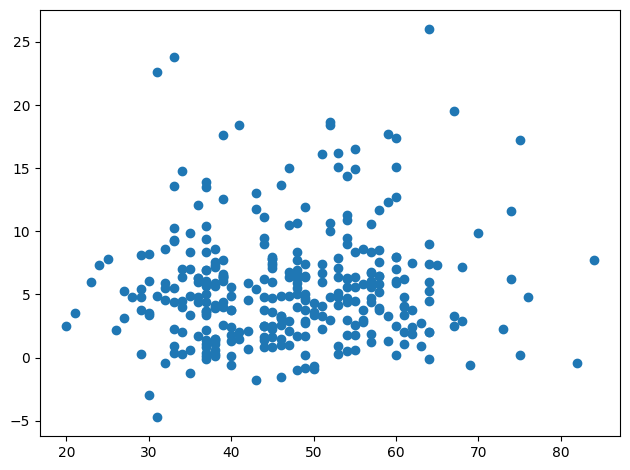

In [1]:
import pandas as pd

sex_dict = {0: "Nữ", 1: "Nam"}
eso_vtq_dict = {0: "Không VTQ", 1: "VTQ LA A", 2: "VTQ LA B", 3: "VTQ LA C"}

d = pd.read_excel("../assets/hrm.xlsx") \
    .replace({
        "sex": sex_dict,
        "eso_LA": eso_vtq_dict
    }) \
    .assign(
        tuoi = lambda x: x["date_exam"].dt.year - x["yob"],
        bmi = lambda x: x["weight"] / x["height"] ** 2,
        fssg_total = lambda x: x.filter(like="q_fssg_").fillna(0).sum(axis=1)
    )


import matplotlib.pyplot as plt

fig, ax = plt.subplots(tight_layout=True)
ax.scatter(d["tuoi"], d["les_irp4s"])
plt.show()

Để đưa tên biến vào các trục của biểu đồ, bạn có thể sử dụng luôn hàm `plot()` của Pandas cho tiện.

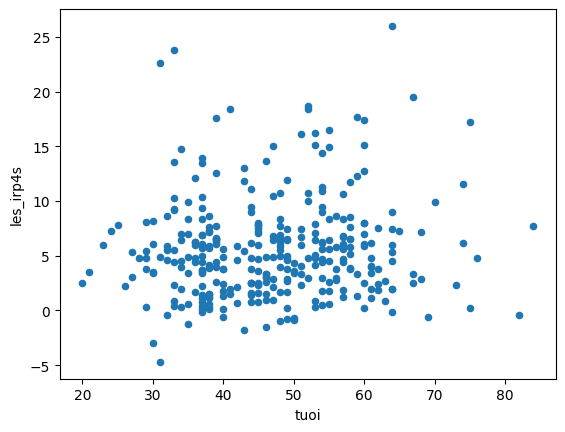

In [2]:
d.plot("tuoi", "les_irp4s", kind="scatter")
plt.show()

Một bước phân tích biểu đồ tiếp theo mà chúng ta thường làm là tô màu các chấm theo một biến danh mục nào đó. Ví dụ chúng ta muốn xem liệu tương quan giữa tuổi và IRP 4s có khác nhau giữa nam và nữ không, chúng ta sẽ "nhóm" các chấm theo giới tính. Để cho nhanh, bạn sẽ dùng thư viện seaborn.

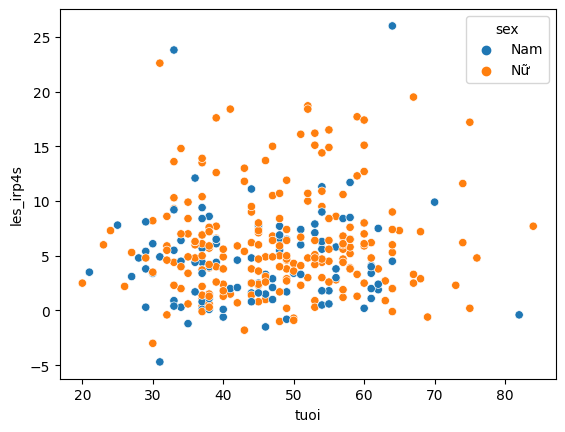

In [3]:
import seaborn as sns

sns.scatterplot(data=d, x="tuoi", y="les_irp4s", hue="sex")
plt.show()

Một tính năng khác khi vẽ scatter plot mà có thể bạn cũng muốn tham khảo là "jittering". Jitter thêm một khoảng dao động nhỏ ngẫu nhiên vào giá trị của các chấm, làm cho các chấm có cùng tọa độ X hoặc Y sẽ tách nhau ra, giúp chúng ta dễ khảo sát hơn. Mặc dù seaborn hỗ trợ công cụ `stripplot()`, nó không thực sự làm được như chúng ta muốn. Bạn có thể tạo ra jittering bằng tay.

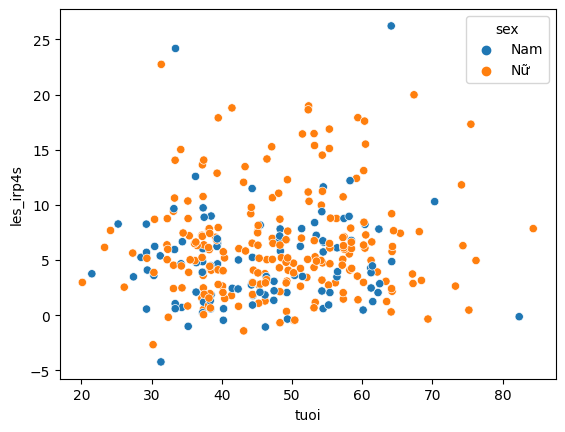

In [4]:
import numpy as np
np.random.seed(0)
d_jitter = d[["tuoi", "les_irp4s"]] + np.random.uniform(0.1, 0.5, size=[d.shape[0], 2])
d_jitter["sex"] = d["sex"]

sns.scatterplot(data=d_jitter, x="tuoi", y="les_irp4s", hue="sex")
plt.show()

## LOWESS plot

LOESS và LOWESS là những phương pháp toán học phức tạp, khi biểu diễn đồ họa, tạo ra các đường cong ước lượng trung bình cục bộ của các chấm trên scatter plot. Hãy cùng xem một ví dụ để hiểu hơn.

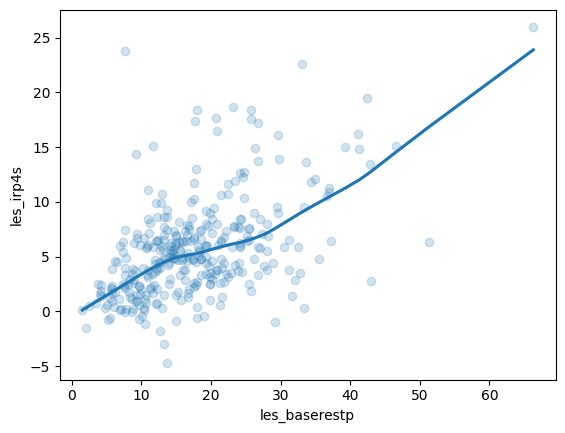

In [5]:
scatter_kws = dict(alpha=0.2)
sns.regplot(data=d, x="les_baserestp", y="les_irp4s", lowess=True, scatter_kws=scatter_kws)
plt.show()

Bạn có thể thấy rằng đường mà seaborn vẽ ra không phải là một đường thẳng, mà là một đường cong. Đường cong này được tính toán dựa trên chính các giá trị quan sát được. Nếu thấy mối tương quan có vẻ là một đường thẳng, bạn có thể sử dụng hồi quy tuyến tính để ước lượng các hệ số của phương trình đường thẳng thể hiện quan hệ giữa hai biến X và Y. Để vẽ chúng, bạn không cần tự chạy hồi quy tuyến tính mà có thể dùng chính hàm `regplot()`.

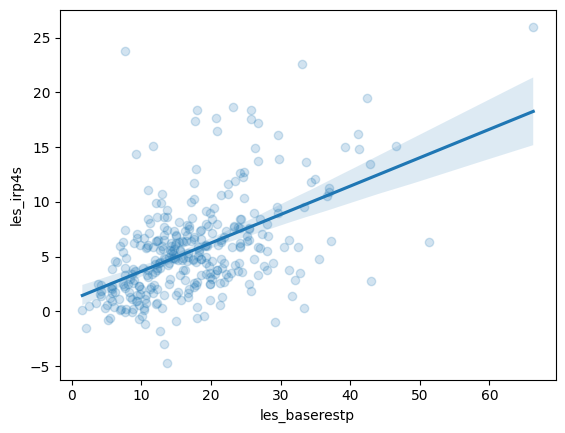

In [6]:
scatter_kws = dict(alpha=0.2)
sns.regplot(data=d, x="les_baserestp", y="les_irp4s", scatter_kws=scatter_kws)
plt.show()

Hàm `regplot()` cũng cho phép bạn jitter số liệu. So sánh hai biểu đồ có và không có jitter để thấy rõ điều này. Mình sẽ tắt khoảng tin cậy của đường thẳng (bằng đối số `ci=None`) để bạn quan sát rõ hơn.

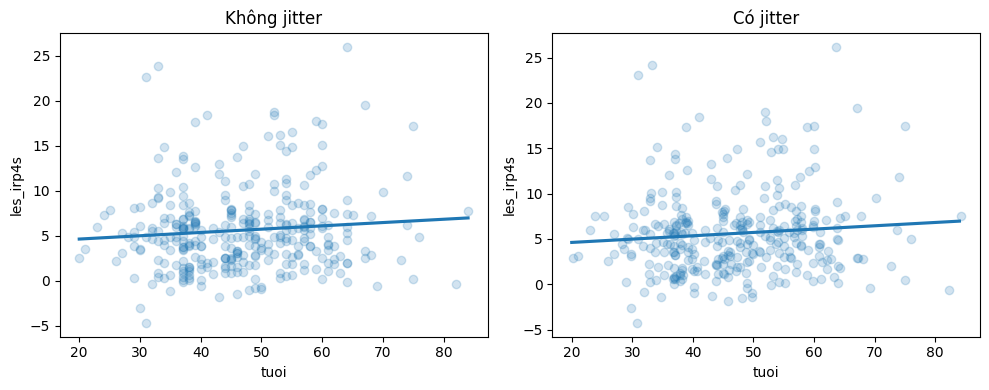

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), tight_layout=True)
scatter_kws = dict(alpha=0.2)
sns.regplot(data=d, x="tuoi", y="les_irp4s",
    ci=None, scatter_kws=scatter_kws, ax=axs[0])
sns.regplot(data=d, x="tuoi", y="les_irp4s",
    ci=None, x_jitter=0.3, y_jitter=0.5, scatter_kws=scatter_kws, ax=axs[1])
axs[0].set_title("Không jitter")
axs[1].set_title("Có jitter")
plt.show()

Hàm `regplot()` cũng cho phép bạn khảo sát mối quan hệ giữa một biến liên tục và một biến nhị phân bằng LOWESS.

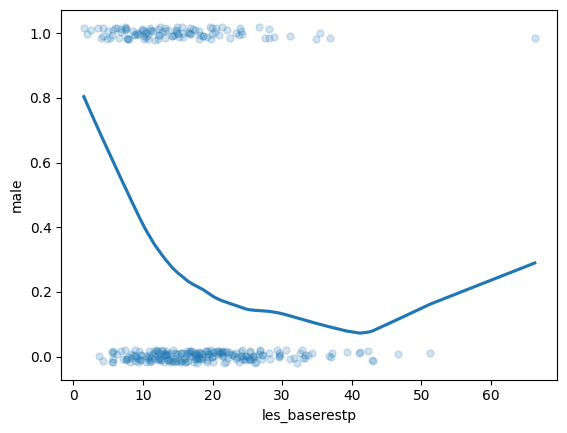

In [8]:
scatter_kws = dict(s=25, alpha=0.2)
d["male"] = d["sex"].eq("Nam").astype(int)
sns.regplot(data=d, x="les_baserestp", y="male", lowess=True,
    y_jitter=0.02, scatter_kws=scatter_kws)
plt.show()

## Error bar

Với những bạn đã quen với việc tính toán và biểu diễn khoảng tin cậy 95% thì error bar chắc không có gì xa lạ. Trước hết chúng ta sẽ cùng tính toán khoảng tin cậy 95% của trung bình IRP 4s của các nhóm tổn thương viêm thực quản.

In [9]:
d_agg = d.groupby("eso_LA")["les_irp4s"] \
    .agg(["mean", "sem"]) \
    .assign(
        error = lambda x: x["sem"] * 1.96
    )

d_agg

,mean,sem,error
eso_LA,,,
Không VTQ,5.673298,0.318397,0.624058
VTQ LA A,5.659000,0.496149,0.972452
VTQ LA B,4.770000,1.203056,2.357990
VTQ LA C,2.733333,1.614862,3.165129


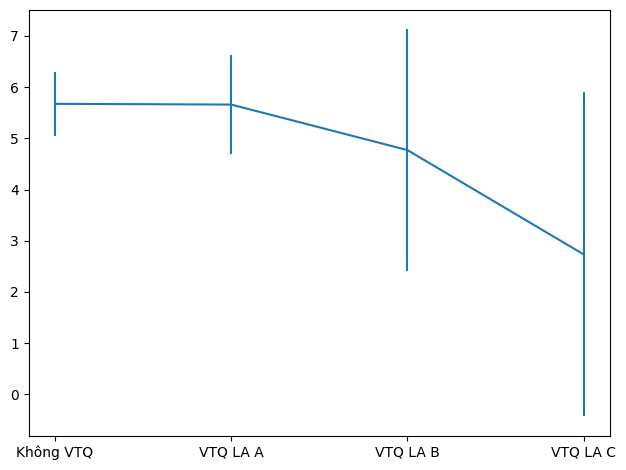

In [10]:
fig, ax = plt.subplots(tight_layout=True)
ax.errorbar(x=d_agg.index, y=d_agg["mean"], yerr=d_agg["error"])
plt.show()

Bạn có thể điều chỉnh các chi tiết trên biểu đồ, ví dụ, thêm các chấm, bỏ đường nối giữa các nhóm, và thêm "mũ" (cap) cho các đường error bar.

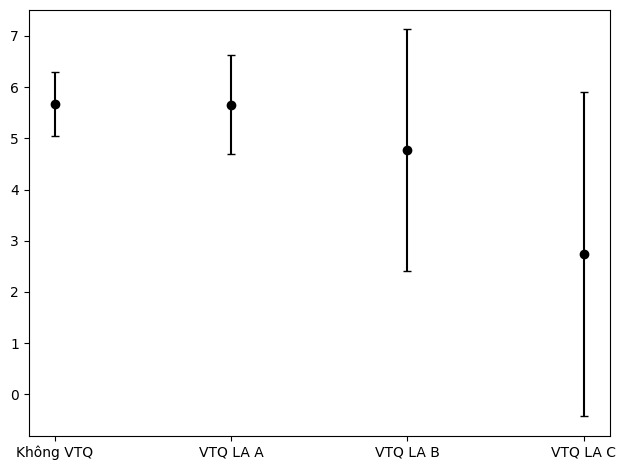

In [11]:
fig, ax = plt.subplots(tight_layout=True)
ax.errorbar(x=d_agg.index, y=d_agg["mean"], yerr=d_agg["error"],
    fmt="ok", capsize=3)
plt.show()

Bạn cũng có thể vẽ trực tiếp bằng Pandas.

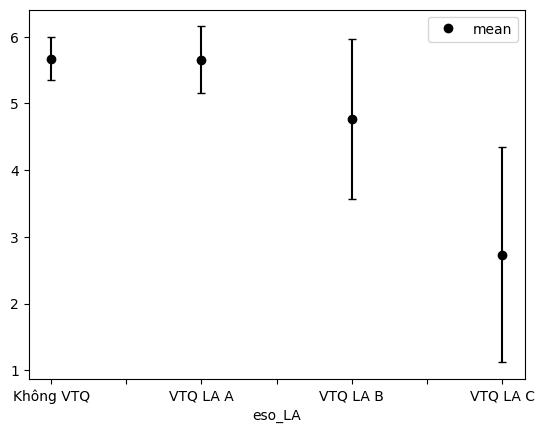

In [12]:
d_agg.reset_index()\
    .plot(x="eso_LA", y="mean", yerr="sem",
        fmt="ok", capsize=3)
plt.show()

## Pairplot

Trong trường hợp muốn khảo sát tương quan giữa nhiều biến liên tục, bạn có thể vẽ scatter plot cho từng đôi một. Biểu đồ này được gọi là pairplot.

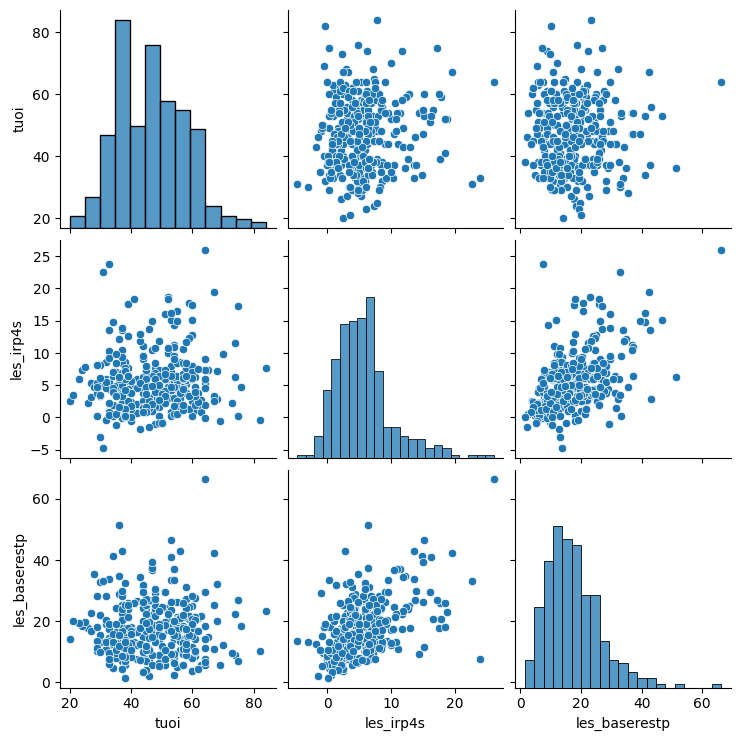

In [13]:
sns.pairplot(d[["tuoi", "les_irp4s", "les_baserestp"]])
plt.show()

Bạn có thể điều chỉnh kiểu biểu đồ cho đường chéo và các ô còn lại.

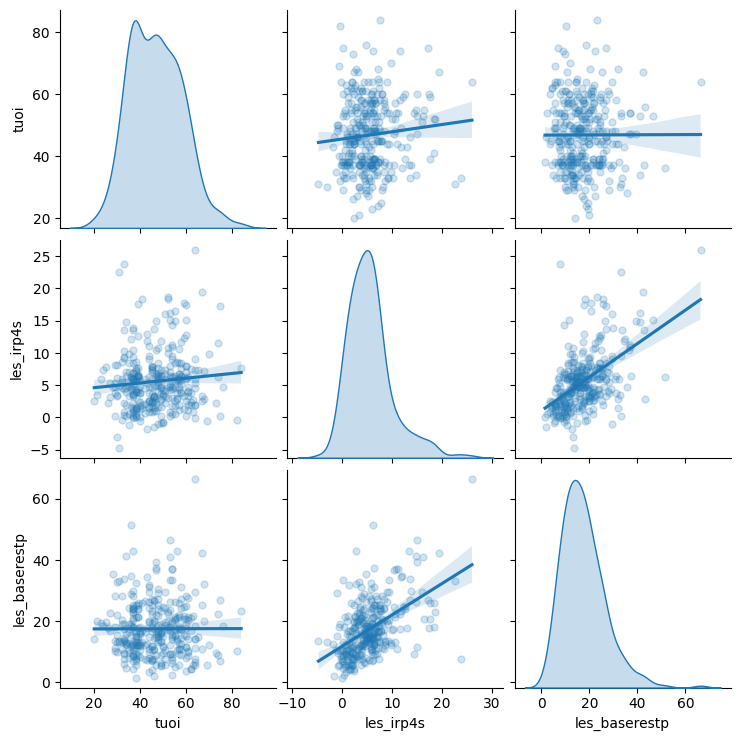

In [14]:
scatter_kws = dict(s=25, alpha=0.2)
plot_kws = dict(scatter_kws=scatter_kws)
sns.pairplot(d[["tuoi", "les_irp4s", "les_baserestp"]], kind="reg", diag_kind="kde", plot_kws=plot_kws)
plt.show()

Cũng như các biểu đồ khác, bạn có thể tô màu cho các chấm theo nhóm.

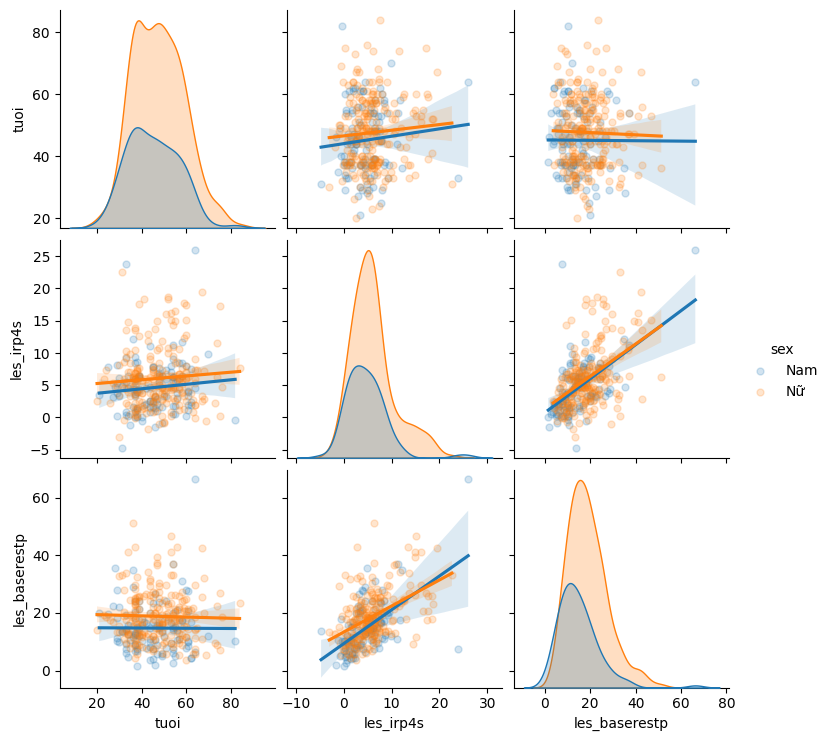

In [15]:
scatter_kws = dict(s=25, alpha=0.2)
plot_kws = dict(scatter_kws=scatter_kws)
sns.pairplot(d[["tuoi", "les_irp4s", "les_baserestp", "sex"]], hue="sex",
    kind="reg", diag_kind="kde", plot_kws=plot_kws)
plt.show()

## Heatmap

Bản đồ nhiệt hay heatmap được sử dụng khi bạn muốn thể hiện các giá trị dưới dạng màu sắc đậm nhạt. Chẳng hạn, với hệ số tương quan Pearson, các giá trị càng gần -1 hoặc 1 thể hiện mức độ tương quan mạnh, càng gần 0 thể hiện sự không tương quan. Trong scatter plot không thể thể hiện chính xác được các con số này, chúng ta có thể dùng heatmap để hiển thị chúng.

Đầu tiên, chúng ta sẽ tính toán hệ số tương quan bằng ma trận hệ số tương quan.

In [16]:
cont_vars = ["tuoi", "bmi", "fssg_total", "les_irp4s", "les_baserestp"]
d_corr = d[cont_vars].corr()
d_corr

,tuoi,bmi,fssg_total,les_irp4s,les_baserestp
tuoi,1.000000,0.105365,-0.133518,0.092688,0.002276
bmi,0.105365,1.000000,-0.172759,-0.127664,-0.128984
fssg_total,-0.133518,-0.172759,1.000000,0.009712,-0.049051
les_irp4s,0.092688,-0.127664,0.009712,1.000000,0.516096
les_baserestp,0.002276,-0.128984,-0.049051,0.516096,1.000000


Đây sẽ là cơ sở để chúng ta vẽ heatmap.

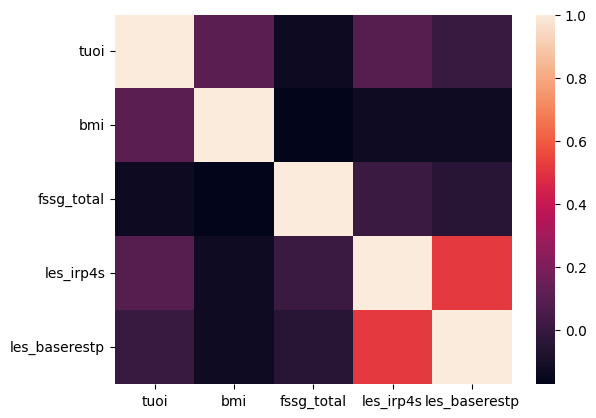

In [17]:
sns.heatmap(d_corr)
plt.show()

Có một vài vấn đề với thang heatmap mà chúng ta vừa tạo:

* Dải màu từ đậm (0) đến nhạt (1). Điều này ngược lại với tư duy thông thường là càng đậm càng gợi ý tương quan chặt chẽ.
* Hệ số tương quan chạy từ -1 đến 1. Chúng ta muốn có hai màu, màu xanh cho giá trị âm, và màu đỏ cho giá trị dương, và chạy từ -1 đến 1.
* Với những giá trị hệ số tương quan loanh quanh +/-0.1, chúng ta muốn loại bỏ chúng để đỡ rối mắt.

Hãy cùng điều chỉnh thiết lập của heatmap để đạt được mục đích này. Matplotlib có một số thang màu ([color map](https://matplotlib.org/stable/gallery/color/colormap_reference.html)) được gọi là "diverging", nghĩa là chúng "chia về hai ngả", chuyển từ một màu sang màu trắng, sau đó chuyển lại sang một màu khác. ở đây chúng ta sử dụng thang màu "RdBu_r" (chuyển từ xanh lam sang trắng rồi sang đỏ).

Để loại bỏ các giá trị loanh quanh +/-0.1, chúng ta sẽ thao tác trên Pandas. Hàm `mask()` thay thế các giá trị trong khoảng này bằng giá trị NA, và điều kiện trong hàm `mask()` là "giá trị tuyệt đối (`abs()`) nhỏ hơn 0.1 (`le()`)".

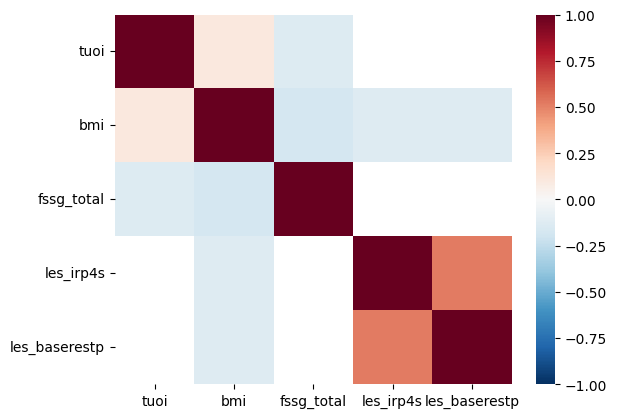

In [18]:
sns.heatmap(d_corr.mask(d_corr.abs().le(0.1)), vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

Bạn có thể thấy rằng với hai thư viện [Matplotlib](https://matplotlib.org/stable/api/index) và [seaborn](https://seaborn.pydata.org/api.html), chúng ta vẽ được rất nhiều biểu đồ thường dùng trong phân tích số liệu. Để tùy biến cho biểu đồ tốt hơn nữa, bạn hãy tự tham khảo các trang web của hai thư viện này để biết thêm ý nghĩa của các đối số khác cho các hàm đồ họa trên đây nhé.

---

[Bài trước](./02_plot.ipynb) - [Danh sách bài](../README.md) - [Bài sau](./04_label.ipynb)